### 条件边
Conditional Edges 允许根据节点的状态动态选择下一个要执行的节点。这在处理需要根据不同情况进行不同决策的场景时非常有用。
### 构造方法
1. 构造routing function
路由函数，就是指对数据到底如何流动进行定义的函数。这种定义利用的就是python中非常基础的if-elif-else的条件判断。
一个基本的routing function的结构如下：
```python
def routing_function(state: AgentState) -> AgentState:
    """This node will select the next node of the graph"""
    if state["KEY"] == 'condition':
        return "edge_1"
    else:
        return "edge_2"
```
要点：
- 一定要注意加docstring，引入LLM之后，LLM会根据我们的注释来操作数据。
- routing_function中的判断条件设置的非常灵活，这里虽然是以判断state的key的内容为例，但实际上你完全可以自定义条件。
- 注意，return返回的边的名字，是一个字符串。
2. 添加条件Node
普通的Node的添加方法：
```python
graph.add_node("node_name", node_function)
```
条件Node的添加方法：
由于routing_function与普通的节点函数不同，它不会对Graph的state数据进行操作，它最多利用state的数据进行一些条件满足方面的判断。因此，事实上输入routing_function的state，与其输出的state，是没有任何差异的。
因此，条件Node的添加方法如下：
```python
graph.add_node("routing_node_name", lambda state: state)
```
3. 添加条件边
利用一个add_conditional_edge方法，这个方法需要三个参数：
- 上游节点的名字：分支从哪个节点出发；
- routing_function：前文已经介绍过了，这里引用一下函数名。
- path_map：一个字典结构的数据，它所包含的键值对就代表分支的走向，每个键值对的结构是：边的名字: 对应的下游节点的名字。

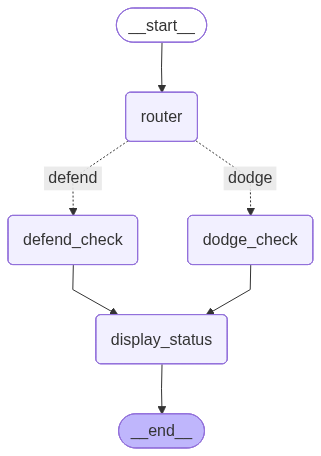

你受到2点伤害

      角色状态信息
职业：法师
等级：1
当前HP：98


In [3]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from IPython.display import Image, display
import random


class AppState(TypedDict):
    char_class: str
    char_level: int
    char_HP: int
    char_action: str


def dodge_check_node(state: AppState) -> AppState:
    """检查闪避结果并处理HP变化
    生成1-6的随机数，如果大于3则闪避成功，否则HP减少特定数值
    """
    dice_roll = random.randint(1, 6)
    if dice_roll > 3:
        print("你成功闪避了伤害")
    else:
        state["char_HP"] = state["char_HP"] - dice_roll
        print(f"闪避失败，受到{dice_roll}点伤害")
    return state


def display_character_status(state: AppState) -> AppState:
    """显示角色状态"""
    print("\n" + "=" * 30)
    print("      角色状态信息")
    print("=" * 30)
    print(f"职业：{state['char_class']}")
    print(f"等级：{state['char_level']}")
    print(f"当前HP：{state['char_HP']}")
    print("=" * 30)
    return state

# 条件边
def decide_next_node(state: AppState) -> AppState:
    """这个节点将选择图的下一个节点"""
    if state["char_action"] == "闪避":
        return "dodge"
    elif state["char_action"] == "防御":
        return "defend"

def defend_check_node(state: AppState) -> AppState:
    """检查防御结果并处理HP变化"""
    dice_roll = random.randint(1, 3)
    state["char_HP"] = state["char_HP"] - dice_roll
    print(f"你受到{dice_roll}点伤害")
    return state

# 激活 StateGraph
graph = StateGraph(AppState)
# 添加节点
graph.add_node("dodge_check", dodge_check_node)
graph.add_node("defend_check", defend_check_node)
graph.add_node("display_status", display_character_status)
graph.add_node("router", lambda state: state)
# 连接节点
graph.add_edge(START, "router")
# 条件边
graph.add_conditional_edges(
    "router",
    decide_next_node,
    {
        "dodge": "dodge_check",
        "defend": "defend_check",
    }
)
graph.add_edge("dodge_check", "display_status")
graph.add_edge("defend_check", "display_status")
graph.add_edge("display_status", END)
# 编译 Graph
app = graph.compile()

# 可视化 Graph
display(Image(app.get_graph().draw_mermaid_png()))

result = app.invoke({"char_class": "法师", "char_level": 1, "char_HP": 100, "char_action": "防御"})
